<a href="https://colab.research.google.com/github/analuizasb2/fetal-health-prediction/blob/main/FetalHealthClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo para Classificação de Saúde fetal baseado em dados de Cardiotocografia

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

## Leitura do dataset

O conjunto de dados contém dados de 2126 fetos, coletados através do exame de cardiotocografia. Eles foram então classificados por profissionais especializados de obstetrícia em estados de saúde: Saudável (1), Suspeito(2) e Patológico (3). Essa classificação pode ser crucial no momento da definição de conduta obstétrica, principalmente em momentos próximos ao parto.

In [3]:

url = "https://raw.githubusercontent.com/analuizasb2/fetal-health-prediction/main/dataset/fetal_health.csv"
dataset = pd.read_csv(url, delimiter=',')
dataset.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## Separação dos conjuntos de treino e teste

Vamos separar 70% dos dados para treinar os modelos e 30% do total do conjunto de dados para ser usados como teste no final (holdout). Utilizaremos estratificação pelo Y, para garantir que no conjunto de teste tenhamos pelo menos uma amostra de cada classe da saída.
Utilizaremos a métrica de acurácia para realizar a escolha do modelo.

In [4]:
seed = 1
array = dataset.values
X = array[:,0:21]
Y = array[:,21]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=seed)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
scoring = 'accuracy'

## Treinamento para seleção do tipo de modelo
Vamos comparar os seguintes tipos de modelos para ver qual deles se adapta melhor a este conjunto de testes:


*   Support Vector Machine (SVM) - Máquina de Vetor de Suporte
*   K-Nearest Keighbours (KNN) - K-Vizinhos mais Próximos
*   Decision Tree - Árvore de Decisão
*   Naive Bayes - Bayes Ingênuo




          model  accuracy       std
0           SVC  0.849497  0.022922
1           KNN  0.887783  0.020541
2  DecisionTree  0.912629  0.019306
3    NaiveBayes  0.804408  0.021797


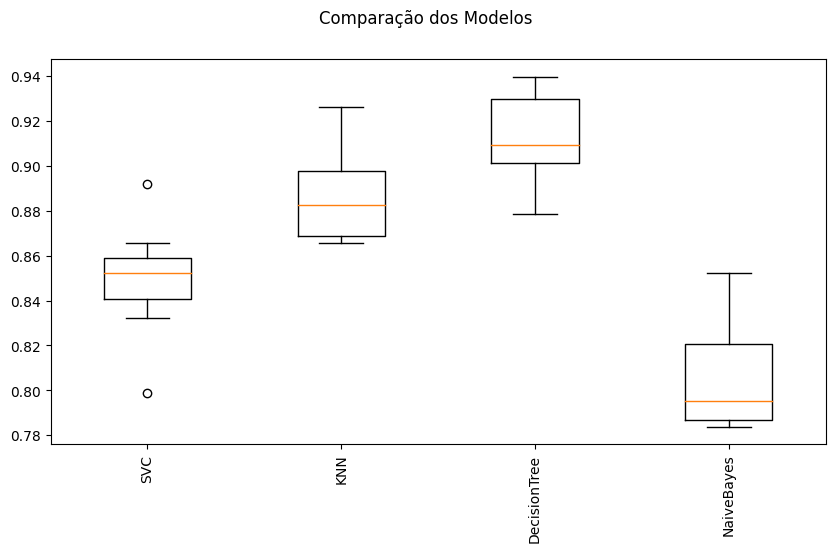

In [5]:
np.random.seed(1)
models = []

models.append(('SVC', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('NaiveBayes', GaussianNB()))

results = []
names = []

results_table = {
    "model": [],
    "accuracy": [],
    "std": []
}

for name, model in models:
  cv_results = cross_val_score(model, Xtrain, Ytrain, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  results_table["model"].append(name)
  results_table["accuracy"].append(cv_results.mean())
  results_table["std"].append(cv_results.std())


df = pd.DataFrame(results_table)
print(df)

fig = plt.figure(figsize=(10,5))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Comparação com dados padronizados e normalizados

Após o teste inicial com tipos de modelos, foi possível perceber que algoritmos do tipo Árvore de Decisão parecem se adaptar melhor ao modelo, gerando melhor acurácia. Mas vamos verificar se esse comportamento se mantém quando padronizamos ou normalizamos os dados, e qual destes pré-processamentos combinado com o modelo é o mais adequado.

                model  accuracy       std
0                 SVC  0.849497  0.022922
1                 KNN  0.887783  0.020541
2        DecisionTree  0.912629  0.019306
3          NaiveBayes  0.804408  0.021797
4            SVC-padr  0.901891  0.021243
5            KNN-padr  0.895828  0.023768
6   DecisionTree-padr  0.908584  0.018689
7     NaiveBayes-padr  0.705573  0.049652
8            SVC-norm  0.891815  0.024426
9            KNN-norm  0.889117  0.020684
10  DecisionTree-norm  0.913972  0.025705
11    NaiveBayes-norm  0.735806  0.044518


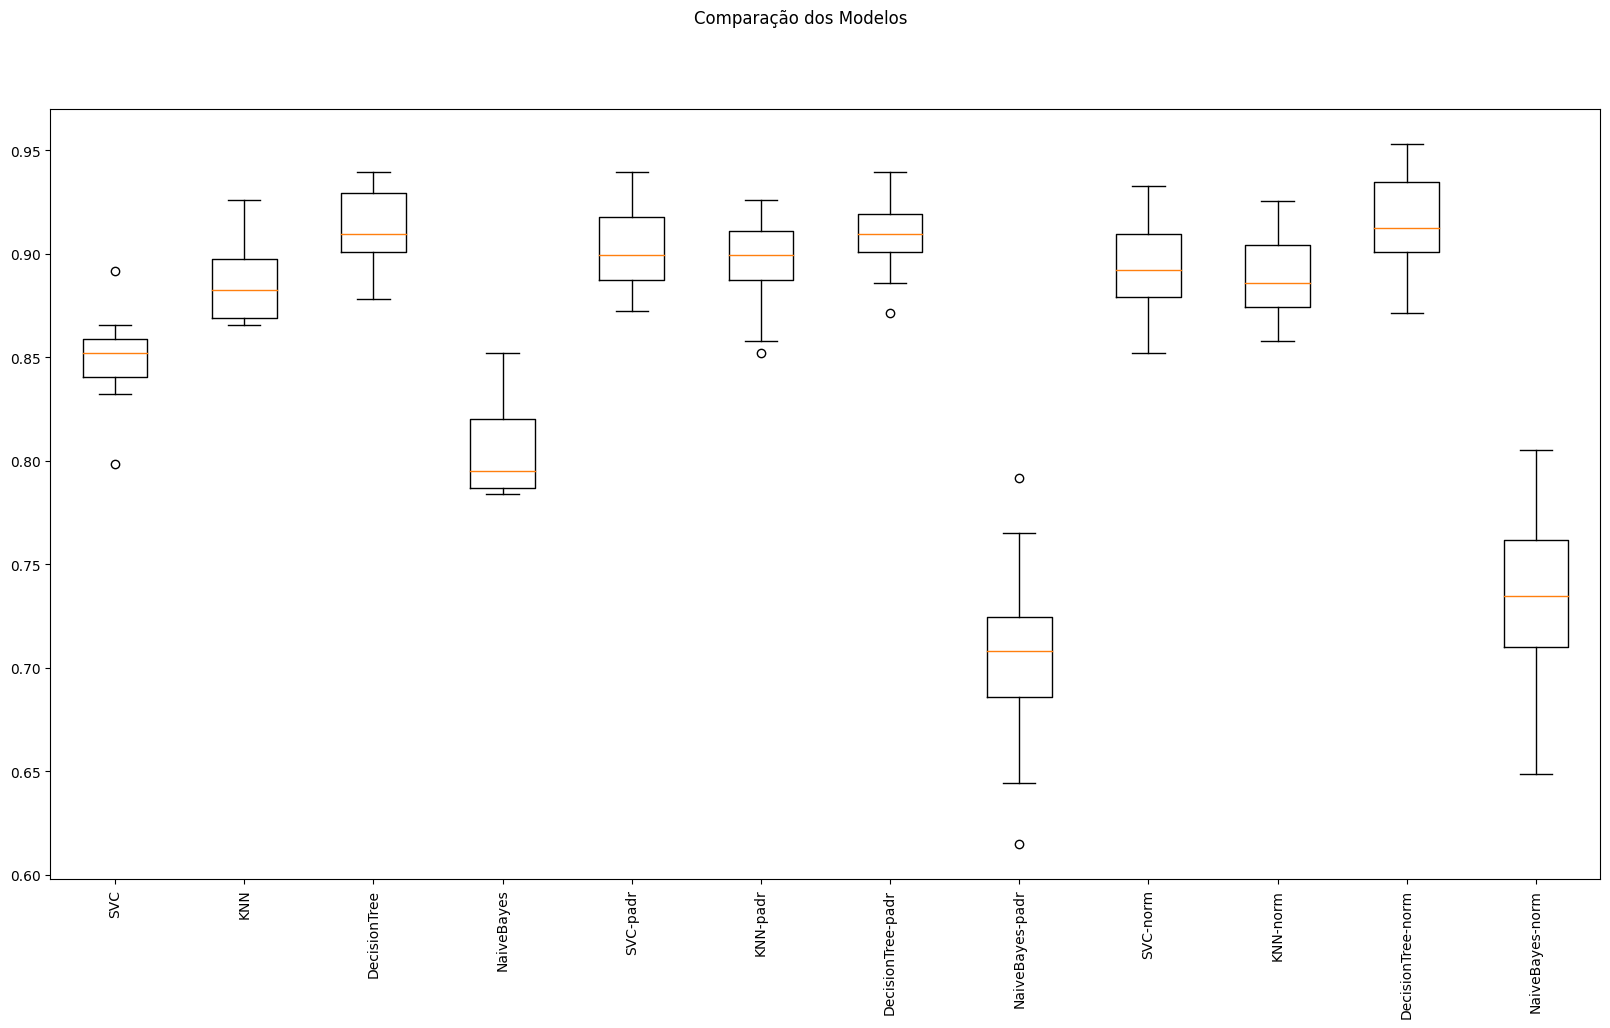

In [6]:
np.random.seed(1)

svc = (('SVC', SVC()))
knn = (('KNN', KNeighborsClassifier()))
decision_tree = (('DecisionTree', DecisionTreeClassifier()))
naive_bayes = (('NaiveBayes', GaussianNB()))

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines = []

pipelines.append(('SVC', Pipeline([svc])))
pipelines.append(('KNN', Pipeline([knn])))
pipelines.append(('DecisionTree', Pipeline([decision_tree])))
pipelines.append(('NaiveBayes', Pipeline([naive_bayes])))

pipelines.append(('SVC-padr', Pipeline([standard_scaler, svc])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('DecisionTree-padr', Pipeline([standard_scaler, decision_tree])))
pipelines.append(('NaiveBayes-padr', Pipeline([standard_scaler, naive_bayes])))

pipelines.append(('SVC-norm', Pipeline([min_max_scaler, svc])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('DecisionTree-norm', Pipeline([min_max_scaler, decision_tree])))
pipelines.append(('NaiveBayes-norm', Pipeline([min_max_scaler, naive_bayes])))

results_table = {
    "model": [],
    "accuracy": [],
    "std": []
}
results = []
names = []

for name, pipeline in pipelines:
  cv_results = cross_val_score(pipeline, Xtrain, Ytrain, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  results_table["model"].append(name)
  results_table["accuracy"].append(cv_results.mean())
  results_table["std"].append(cv_results.std())


df = pd.DataFrame(results_table)
print(df)

fig = plt.figure(figsize=(20,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Otimização de hiperparâmetros

O algoritmo de árvore de decisão continuou sendo o melhor, porém entre dados normalizados e padronizados, ou nenhum tipo de pré-processamento, os resultados estão bastante similares. Vamos realizar a otimização de hiperparâmetros com todos estes e verificar qual deles tem melhor acurácia.

In [7]:
np.random.seed(1)

pipelines = []

pipelines.append(('DecisionTree', Pipeline(steps=[decision_tree])))
pipelines.append(('DecisionTree-norm', Pipeline(steps=[min_max_scaler, decision_tree])))
pipelines.append(('DecisionTree-padr', Pipeline(steps=[standard_scaler, decision_tree])))

param_grid = {
    'DecisionTree__max_depth': [3, 5, 10, 20, 30, 40],
    'DecisionTree__min_samples_split': [2, 5, 10, 15, 20, 30],
    'DecisionTree__min_samples_leaf': [1, 2, 4, 8, 16, 32],
    'DecisionTree__criterion': ['gini', 'entropy']
}

for name, model in pipelines:
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring=scoring)
  grid.fit(Xtrain, Ytrain)
  print(name, grid.best_score_, grid.best_params_)

DecisionTree 0.9267186649736987 {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': 30, 'DecisionTree__min_samples_leaf': 2, 'DecisionTree__min_samples_split': 5}
DecisionTree-norm 0.9267231997097769 {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': 20, 'DecisionTree__min_samples_leaf': 2, 'DecisionTree__min_samples_split': 15}
DecisionTree-padr 0.926056593506258 {'DecisionTree__criterion': 'gini', 'DecisionTree__max_depth': 30, 'DecisionTree__min_samples_leaf': 2, 'DecisionTree__min_samples_split': 20}


## Finalização do modelo e Teste com holdout
Os resultados da otimização de hiperparâmetros mostraram que o melhor modelo foi o de árvore de decisão com dados **normalizados**, com os seguintes parâmetros:
*   Critério: Índice Gini
*   Profundidade máxima: 20
*   Número mínimo de amostras para um nó folha: 2
*   Número mínimo de amostras para dividir um nó: 15

Criaremos então o normalizador e o modelo final com estes parâmetros, e testaremos com os 30% dos dados que separamos inicialmente para verificar a sua acurárcia com dados nunca vistos.


In [9]:
np.random.seed(1)

scaler = MinMaxScaler().fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)

model = DecisionTreeClassifier(criterion= 'gini', max_depth=20, min_samples_leaf=2, min_samples_split=15)
model.fit(Xtrain_scaled, Ytrain)

Xtest_scaled = scaler.transform(Xtest)
result = model.predict(Xtest_scaled)

print(accuracy_score(Ytest, result))


0.8996865203761756


## Exportação do modelo

Já que este modelo apresentou uma acurácia de 90% com dados não vistos, consideramos que ele tem uma boa qualidade, conseguindo classificar bem os dados dos fetos.

In [10]:
filename = 'scaler_fetalhealth.pkl'
pickle.dump(scaler, open(filename, 'wb'))

filename = 'model_fetalhealth.pkl'
pickle.dump(model, open(filename, 'wb'))

X_test_df = pd.DataFrame(Xtest, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(Ytest, columns=[dataset.columns[-1]])
X_test_df.to_csv("X_test_dataset.csv", index=False)
y_test_df.to_csv("y_test_dataset.csv", index=False)

## Conclusões da análise

O conjunto de dados de saúde fetal foi melhor classificado utilizando-se algoritmos de **árvore de decisão**. Com a normalização dos dados utilizando este modelo, observou-se melhor acurácia e um baixo desvio padrão, sendo assim este o modelo que realizou as melhores predições.

Após a otimização dos hiperparâmetros, o modelo padronizado continuou com a melhor acurárcia, sendo esta otimizada quando utilizado o critério de Índice Gini, com Profundidade Máxima da árvore de 20, o Número mínimo de amostras para dividir um nó de 2 e o Número mínimo de amostras para um nó folha de 15.

Este modelo apresentou a melhor capacidade de predição se o estado de saúde do feto era Saudável (1), Suspeito (2) ou Patológico (3), sendo assim um potencial aliado a profissionais de saúde na intepretação de resultados quando na avaliação de gestantes através do exame de cardiotocografia.